In this notebook we'll look into the vaccination data and try to visualise, interpret and prepare it for use in the Skygrid + covariates and genetic GLM analyses.

In [1]:
library(ggplot2)
library(reshape2)

In [2]:
vac.data <- read.table("../../DATA/EPI_DATA/vac_FMD.txt", header = TRUE)

In [3]:
vac.data

Year,Argentina,Bolivia,Brazil,Colombia,Ecuador,Paraguay,Peru,Uruguay,Venezuela,Mean,Median
1986,2.50,0.52,2.40,1.62,0.45,1.50,0.20,1.96,0.71,1.32,1.50
1987,3.27,0.32,2.00,1.26,0.32,1.39,0.23,3.04,0.71,1.39,1.26
1988,2.50,0.38,2.55,0.97,0.30,1.74,0.02,3.49,1.04,1.44,1.04
1989,2.48,0.04,1.71,1.00,0.26,1.24,0.10,3.03,0.67,1.17,1.00
1990,3.03,NA,1.67,1.06,0.32,1.55,0.19,3.29,0.91,1.50,1.30
1992,1.49,NA,1.50,0.51,0.23,1.26,0.19,2.28,0.81,1.03,1.04
1993,1.80,0.19,1.32,0.91,0.30,0.84,NA,2.00,0.90,1.03,0.91
1994,1.91,0.85,1.45,0.55,0.25,1.09,0.50,1.69,0.64,0.99,0.85
1995,1.79,0.85,1.36,0.79,0.30,1.36,1.09,NA,0.02,0.94,0.97
1997,1.34,0.85,1.99,1.10,0.28,1.45,0.33,NA,0.96,1.04,1.03


In [4]:
vac.data.dt <- reshape2::melt(vac.data[, -c(11, 12)], id = c("Year"),
                       variable.name = "country", value.name = "doses_per_head")

In [5]:
options(repr.plot.width=8, repr.plot.height=6)

Warning message:
“Removed 10 rows containing missing values (geom_path).”Warning message:
“Removed 27 rows containing missing values (geom_point).”

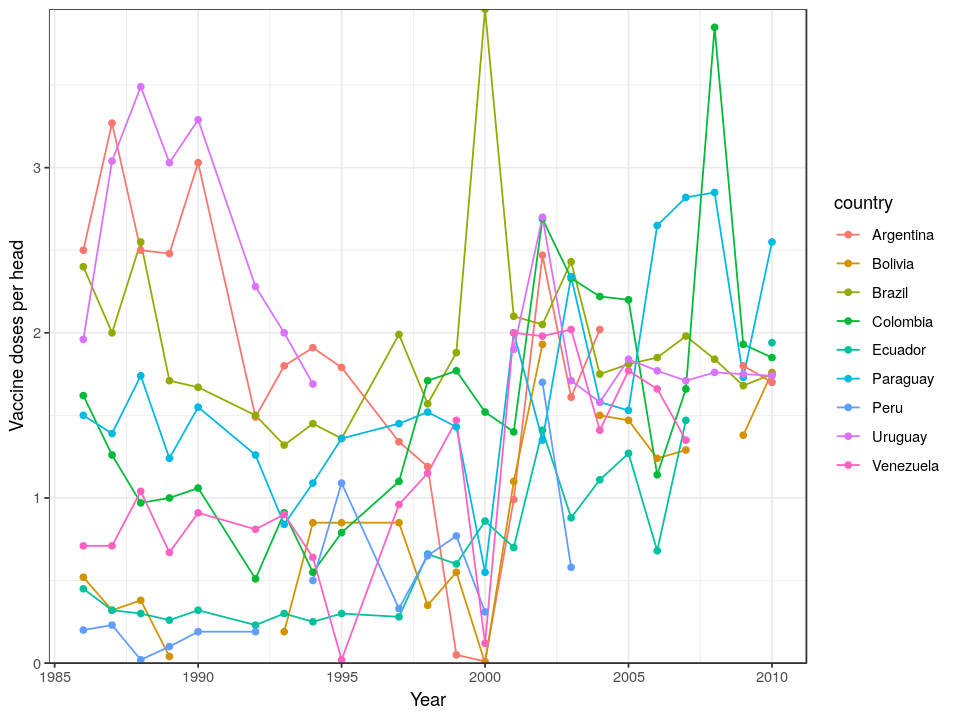

In [6]:
z <- ggplot(vac.data.dt, aes(x = Year, y = doses_per_head, fill = country, colour = country)) +
    geom_line() +
    geom_point() +
#     stat_summary(aes(y = doses_per_head, group = 1), fun.y = mean, colour = "black", geom = "line", group = 1) + 
#     geom_smooth() +
    scale_y_continuous("Vaccine doses per head", expand = c(0, 0)) +
    theme_bw() + 
NULL
z

In [7]:
ggsave("~/Dropbox/FMDV_AMERICA/REPO/FIGURES/PLOTS/vaccination_per_country_time.pdf", plot = z)

Saving 6.67 x 6.67 in image
Warning message:
“Removed 10 rows containing missing values (geom_path).”Warning message:
“Removed 27 rows containing missing values (geom_point).”

Lots of heterogeneity across countries and time.

In [13]:
# see http://www.cookbook-r.com/Graphs/Plotting_means_and_error_bars_(ggplot2)/#Helper%20functions
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

In [14]:
avg.vac

Year,N,doses_per_head,sd,se,ci
1986,9,1.3177778,0.8742251,0.29140835,0.6719889
1987,9,1.3933333,1.1588572,0.38628573,0.8907765
1988,9,1.4433333,1.1973199,0.39910664,0.9203416
1989,9,1.1700000,1.0607191,0.35357303,0.8153409
1990,8,1.5025000,1.1480760,0.40590617,0.9598156
1992,8,1.0337500,0.7282256,0.25746662,0.6088118
1993,8,1.0325000,0.6462806,0.22849469,0.5403041
1994,9,0.9922222,0.5789382,0.19297940,0.4450113
1995,8,0.9450000,0.5836095,0.20633710,0.4879097
1997,8,1.0375000,0.5717579,0.20214696,0.4780016


In [15]:
avg.vac <- summarySE(vac.data.dt, measurevar = "doses_per_head", groupvars = c("Year"), na.rm = TRUE)
write.csv(avg.vac, file = "../../DATA//EPI_DATA/vaccination_temporal_summaries.csv", row.names = FALSE)

NULL

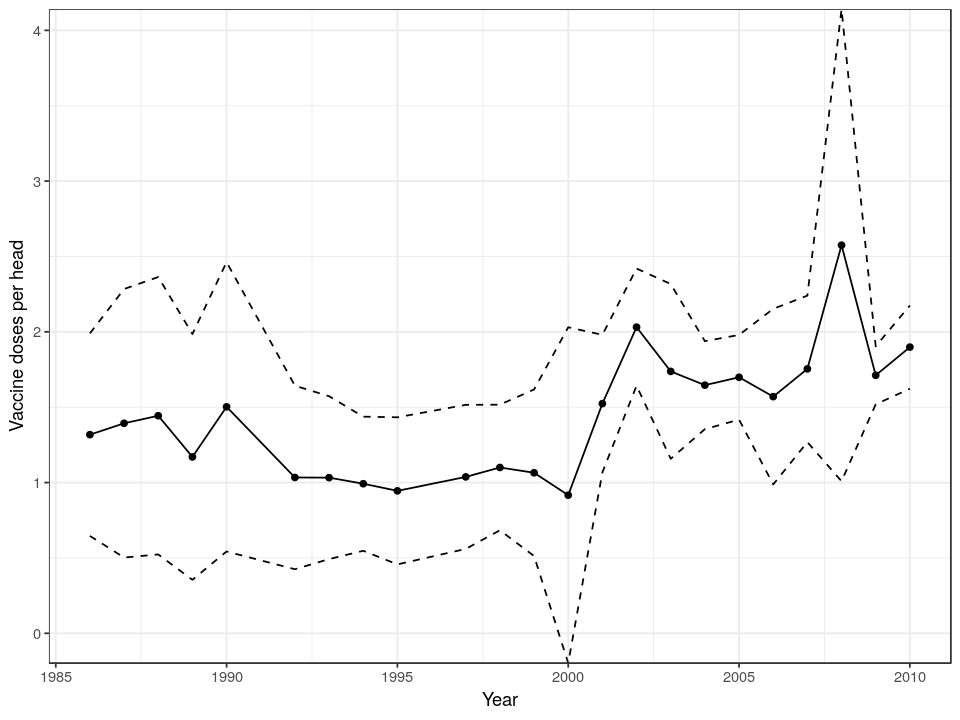

In [16]:
z2 <- ggplot(avg.vac, aes(x = Year, y = doses_per_head)) +
    geom_point() + #size = avg.vac$N
    geom_line() +
    geom_line(data = avg.vac, aes(x = Year, y = doses_per_head + ci), linetype = "dashed")+
    geom_line(data = avg.vac, aes(x = Year, y = doses_per_head - ci), linetype = "dashed")+
    scale_y_continuous("Vaccine doses per head", expand = c(0, 0)) +
    theme_bw()
NULL
z2

In [17]:
ggsave("~/Dropbox/FMDV_AMERICA/REPO/FIGURES/PLOTS/vaccination_overall_time.pdf", plot = z2)

Saving 6.67 x 6.67 in image
